# TP Machine Learning K plus proches voisins

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import metrics
from scipy import stats
from sklearn import neighbors
from sklearn import datasets
from sklearn import metrics
from sklearn import linear_model
from sklearn.lda import LDA
from tpknnsource import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d, ErrorCurve,frontiere_new, LOOCurve)
import seaborn as sns
from matplotlib import rc
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

/home/raphael/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/home/raphael/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': '.15',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.linewidth': 1.25,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': '-',
 'image.cmap': 'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.major.size': 0.0,
 'xtick.minor.size': 0.0,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.major.size': 0.0,
 'ytick.minor.size': 0.0}

In [105]:
np.random.seed(42)  # fix seed globally

n = 100
mu = [1., 1.]
sigma = [1., 1.]
rand_gauss(n, mu, sigma)

n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

n1 = 25
n2 = 25
n3 = 25
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
sigma3 = [0.9, 0.9]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

n1 = 50
n2 = 50
sigma1 = 1.
sigma2 = 5.
X3, y3 = rand_clown(n1, n2, sigma1, sigma2)

n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = rand_checkers(n1, n2, sigma)

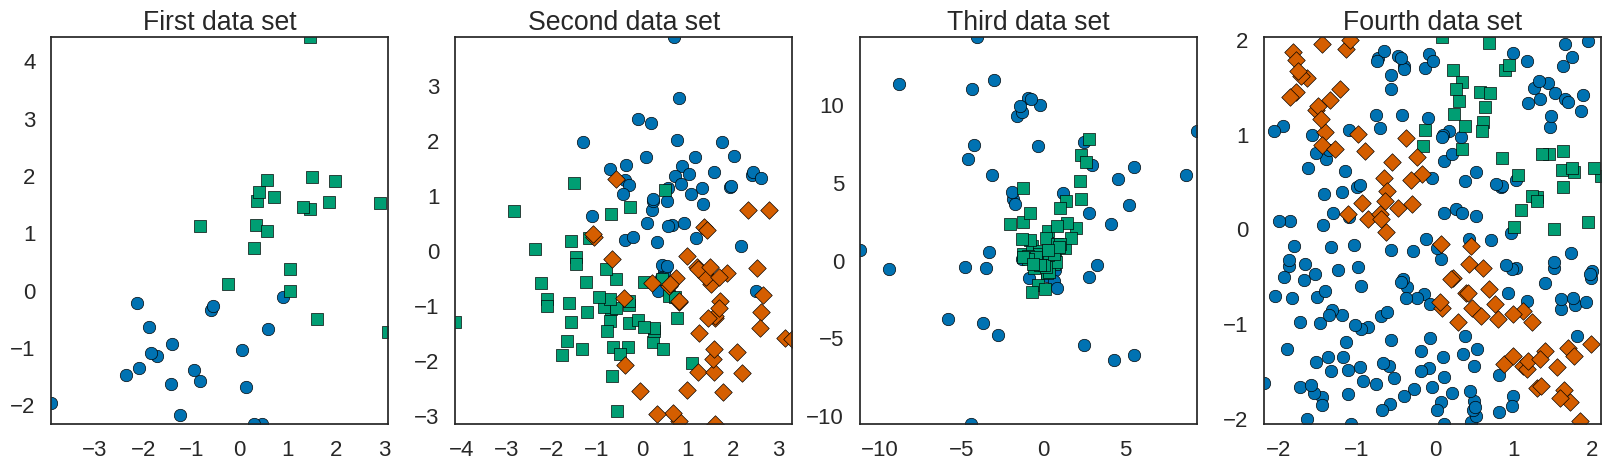

In [4]:
plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(20, 5))
plt.subplot(141)
plt.title('First data set')
plot_2d(X1, y1)

plt.subplot(142)
plt.title('Second data set')
plot_2d(X2, y2)

plt.subplot(143)
plt.title('Third data set')
plot_2d(X3, y3)

plt.subplot(144)
plt.title('Fourth data set')
plot_2d(X4, y4)

In [121]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        closest = np.argsort(metrics.pairwise_distances(X, self.X_))
        n_closest = [arr[:self.n_neighbors] for arr in closest]
        return [stats.mode(self.y_[p])[0][0] for p in n_closest]
    
    def predictweighted(self, X):
        def weightedDist(distance):
            return np.exp(- distance**2 / 50)
        # Liste des labels
        labels = np.unique(self.y_)
        # Calculer les distances ponderées des voisins
        closest = np.argsort(metrics.pairwise_distances(X, self.X_))
        weights = weightedDist(closest)
        # Trouver les voisins ordonnés par la distance exponentielle.
        neighbours = np.argsort(closest)
        # Conserver les index des n plus proches voisins.
        n_closest_points = [arr[self.n_neighbors:] for arr in neighbours]
        # Conserver les index des n plus forts poids
        n_closest_weights = [arr[self.n_neighbors:] for arr in weights]
        # Pour chaque ligne du test set 
        # sommer les poids par label
        sums = []
        for label in labels :
            weighted_by_label = np.sum((self.y_[n_closest_points] == label) * n_closest_weights, axis = 1)
            sums.append(weighted_by_label)
        return np.argmax(sums, axis = 0)    

In [108]:
# Prédiction sur x2, y2
X_train = X2[::2]
Y_train = y2[::2].astype(int)
X_test = X2[1::2]
Y_test = y2[1::2].astype(int)

clf = KNNClassifier(n_neighbors= 3)
clf.fit(X_train, Y_train)
y_hat = clf.predict(X_test)

In [109]:
clf_sk = neighbors.KNeighborsClassifier(n_neighbors=3)
clf_sk.fit(X_train, Y_train)
y_hat2 = clf_sk.predict(X_test)

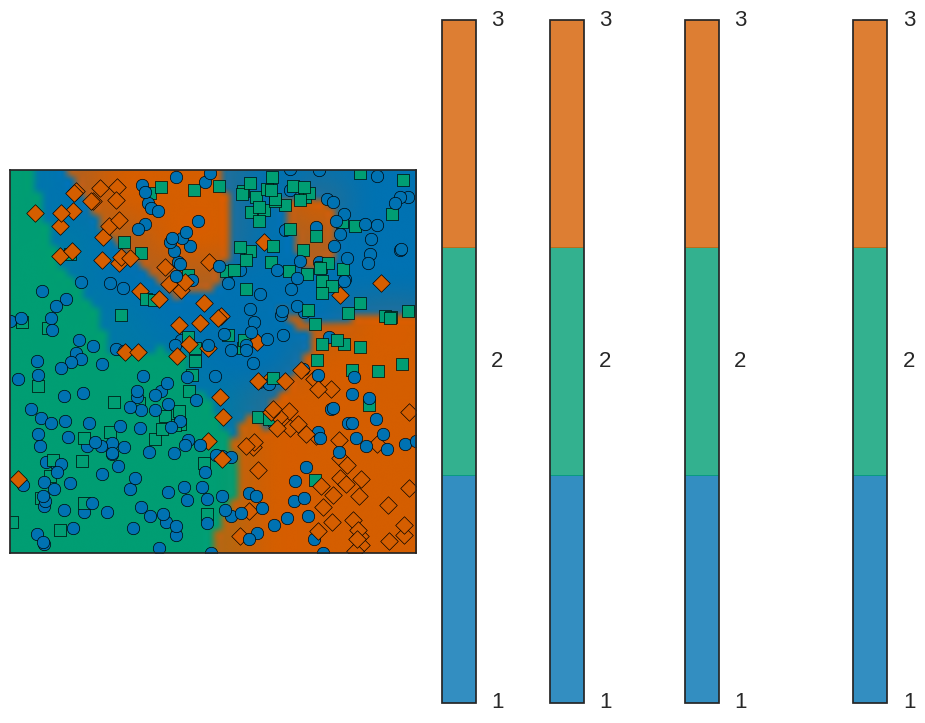

In [110]:
for X, y in [(X1, y1), (X2, y2), (X3, y3), (X4, y4)]:
    frontiere_new(clf_sk.predict,X,y)

[]

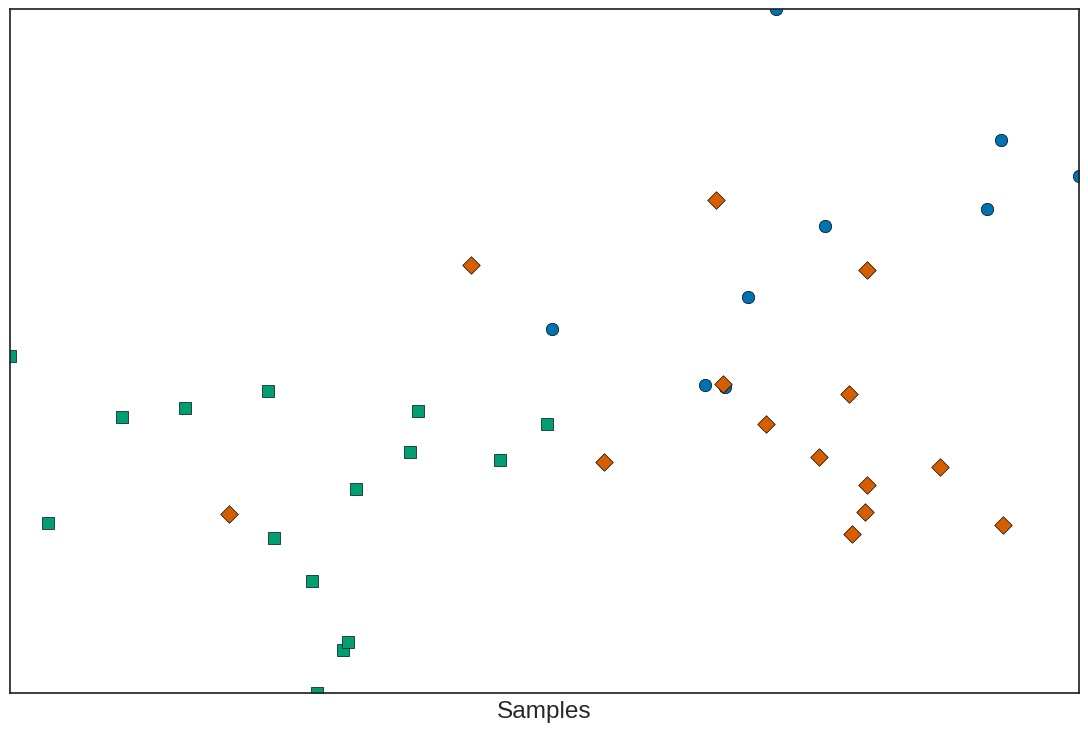

In [111]:
plt.figure(3, figsize=(80, 30))
plt.subplot(3, 5, 3)
plot_2d(X_train, Y_train)
plt.xlabel('Samples')
ax = plt.gca()
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

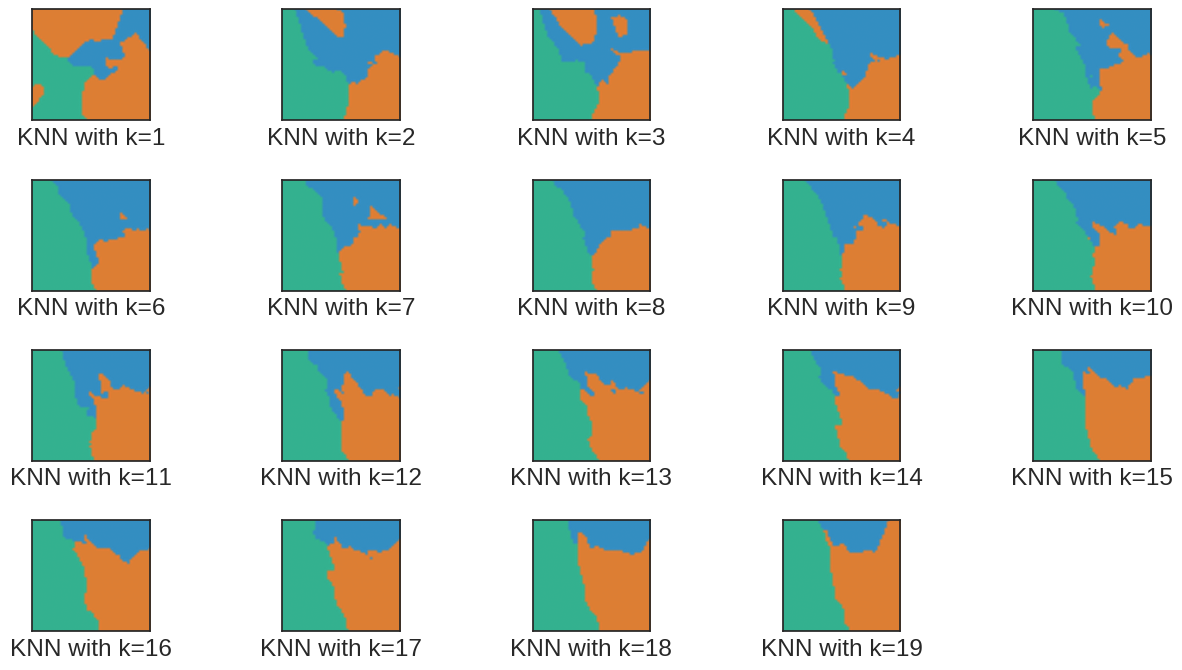

In [112]:
def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return knn.predict(xx.reshape(1, -1))

for n_neighbors in range(1, 20):
    knn = neighbors.KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, Y_train)
    plt.subplot(5, 5, 5 + n_neighbors)
    plt.xlabel('KNN with k=%d' % n_neighbors)
    frontiere_new(f, X, y, w=None, step=50, alpha_choice=1,
                  colorbar=False, samples=False)
    plt.draw()  # update plot

plt.tight_layout()

In [124]:
clf = KNNClassifier(n_neighbors= 3)
clf.fit(X_train, Y_train)
y_hat = clf.predictweighted(X_test)
print("\n", y_hat)
print(np.sum(Y_test == y_hat))


[[12  5  4 ..., 20 26 11]
 [25 22  0 ..., 12 34  4]
 [ 5 12  4 ...,  0 11 20]
 ..., 
 [29  5 37 ..., 31  6  1]
 [ 5 29 12 ..., 20  9 19]
 [29  5 37 ..., 23  6  1]]

 [2 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 1 1 2 2 2]
12
